In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util.cifar10_loader import Cifar10Loader
from util.data_visualizer import DataVisualizer

### Load and Visualize CIFAR 10 Data into train, test

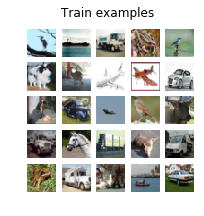

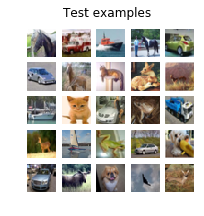

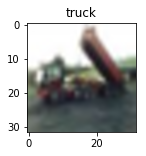

In [546]:
model_path = './models'
data_loader = Cifar10Loader()
dv = DataVisualizer()

X_train, y_train, X_test, y_test, labels = data_loader.load_cifar10('./Datasets/cifar-10')

# data_visualizer expects unflatted images
dv.visualize_data(X_train, 'Train examples')
dv.visualize_data(X_test, 'Test examples')

# Flatten data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Verify Flattened data
image_id = 2
dv.visualize_image(X_train[image_id].reshape(32, 32, 3), labels[y_train[image_id]])

# Utilities

In [487]:
from scipy.special import expit

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_alternate(x):
    return expit(x)

# Division by Std dev need not be because the initial image is already in range of 0 to 1 
# due to earlier division by 255. So now all the different features (pixels) are in similar scale.
# TODO: Check for improvements post division
def preprocess_data(X, X_mean=None, X_std=None, divide_by_std_dev=False, view_hists=False):
    if X_mean is None:
        X_mean = np.mean(X, axis=0)
    if X_std is None:
        X_std = np.std(X, axis=0)
    X_1 = X - X_mean
    X_2 = X_1/X_std

    if view_hists == True:
        fig, axes1 = plt.subplots(3,1,figsize=(7,7))
        plt.suptitle('Histogram of 0th pixel of all examples')
        axes1[0].set_title('data')
        axes1[0].hist(X[:,0])
        axes1[1].set_title('data - Mean(data)')
        axes1[1].hist(X_1[:,0])
        axes1[2].set_title('(data - Mean(data))/Std_dev(data)')
        axes1[2].hist(X_2[:,0])

    if divide_by_std_dev is True:
        return X_2, X_mean, X_std
    else:
        return X_1, X_mean, X_std

def append_ones(X):
    return np.concatenate((X, np.ones((X.shape[0], 1), dtype=int)), axis=1)

def generate_binary_classification_label_from_multiclass_labels(labels, num_classes):
    # Generate 10 sets of labels for each class
    binary_labels = np.zeros((10, labels.shape[0]), dtype=int)
    for i in range(num_classes):
        binary_labels[i] = (labels == i)
    return binary_labels

# Logistic Regression

#### TODO:
- Try dimensionality reduction (PCA)
- Try equal number of positive and negative samples
- Adaptive learning rate
- Momentum
- Compare against tensorflow/keras
- Display some of images which failed
- Validation split
- Stochastic vs Mini-batch vs batch

#### Learnings:
- Important to initialize weights to very very small - especially for batch GD. 
  Hence dividing randomly initialized weights from a uniform distribution by number of examples. 
  Else log(1-sigmoid(w.x)) will lead to -infinity.
- For Class 0, tried input with and without dividing my standard deviation. The accuracy went slightly up when
  divided by standard deviation. It seems like a good practice to follow.
  - Without dividing my std dev:
        Accuracy on Training data =  90.956
        Accuracy on Test data =  90.97
  - Dividing my std dev:
        Accuracy on Training data =  91.24 (1550)
        Accuracy on Test data =  91.04 (302)
- This accuracy is still pretty poor as the number of predicted 1s are only 1550 among 5000 samples of this class.
  One reason can be that we have too many negative samples. 
- Regularization:
  - Using L2 norm (sum of squares of weights)
  - Prevents overfitting to the training data, ensures lowest multiple of weights is considered.
  - Penalizing large weights tends to improve generalization as no input dimension can have a very large influence on the scores all by itself. Ex: Input vector x=[1,1,1,1], and two weight vectors w1=[1,0,0,0], w2=[0.25,0.25,0.25,0.25]. Then w1.x = w2.x = 1, but L2 penalty of w1 = 1, while L2 penalty of w2 = 0.25. Therefore, w2 is preferred since it achieves a lower regularization loss. Intuitively, this is because the weights in w2 are smaller and more diffuse. Since the L2 penalty prefers smaller and more diffuse weight vectors, the final classifier is encouraged to take into account all input dimensions to small amounts rather than a few input dimensions and very strongly.This effect can improve the generalization performance of the classifiers on test images and lead to less overfitting.
  - Don't divide regularization factor by number of training examples.
  - Without regularization:
        Accuracy on Training data =  91.24 1550
        Accuracy on Test data =  91.04 302
  - With regularization:
        Accuracy on Training data =  91.142 1883
        Accuracy on Test data =  91.14 366
  - From values above, there was minor overfitting without regularization.
  - Also, viewing weights (lots of black areas), regularization prefers lower values of weights.


## Next Steps:
- Softmax Classification
- SVM

In [516]:
import time

class LogisticRegression():
    def __init__(self, verbose=True):
        self.weights = None
        self.verbose = verbose
        self.loss_mse_list = []

    def _initialize_weights(self):
        self.loss_mse_list = []
        # define weights - random from uniform distribution over [0,1] or initialize to 0?
        self.weights = np.random.rand(X_train_lr.shape[1], 1)/self.num_train_data

    def train(self, X, y, num_epochs, learning_rate=0.01, initialize_weights=False, gradient_descent_type='batch',
             enable_regularization=False, regularization_rate=0.001):
        """
        Train the classifier
        Parameters
        ----------
        X: (N x M) nd-array of dtype=float where N is the size of train dataset, M is the number of features
        y: (N x 1) nd-array of dtype=int where N is the size of train dataset
        """
        self.num_train_data = X.shape[0]
        if self.num_train_data != y.shape[0]:
            raise ValueError("Train Data size and Label size don't match")

        if self.weights is None or initialize_weights is True:
            self._initialize_weights()
        
        for i in range(num_epochs):
            # Forward Propagation
            y_pred = sigmoid(np.dot(X, self.weights))
            if np.isnan(y_pred).all() is True or np.isfinite(y_pred) is False:
                print('Predicted labels have nan or infinity in it')
                break
            y_diff = y_pred - y
            loss_mse = -np.sum((y*np.log(y_pred) + (1-y)*np.log(1-y_pred)))/self.num_train_data

            if enable_regularization is True:
                # Don't include bias while summing up weights
#                loss_mse = loss_mse + (regularization_rate*np.sum(np.square(self.weights[:-1]))/self.num_train_data)
                loss_mse = loss_mse + regularization_rate*np.sum(np.square(self.weights[:-1]))
            
            # Back Propagation
            derivative_loss = np.dot(X.T, y_diff)
            self.weights = self.weights - (learning_rate / self.num_train_data) * derivative_loss

            if enable_regularization is True:
                #self.weights = self.weights - (learning_rate * regularization_rate / self.num_train_data)*self.weights
                self.weights = self.weights - (learning_rate * regularization_rate)*self.weights

            self.loss_mse_list.append(loss_mse)
            if self.verbose is True and i%100 == 0:
                print('Iteration {}: Loss = {}'.format(i, loss_mse))
        plt.title('Training Loss')
        plt.plot(self.loss_mse_list)

        
    def predict(self, X):
        y_pred_float = sigmoid(np.dot(X, self.weights))
        return (y_pred_float >= 0.5).astype(int)

    def get_accuracy(self, y_ground_truth, y_predicted):
        """
        Computes accuracy
        Parameters
        ----------
        y_ground_truth: (N x 1) nd-array of dtype=int
        y_predicted: (N x 1) nd-array of dtype=int
        Returns:
        accuracy of type float
        """
        return(100*np.mean(y_predicted == y_ground_truth))
    
    def save_model(self, filename):
        np.save(filename, self.weights)

    def load_model(self, filename):
        self.weights = np.load(filename)

    def visualize_weights(self):
        weight_image = self.weights[:3072].reshape(32, 32, 3)
        print("Bias = ", self.weights[-1])
        fig, axes1 = plt.subplots(4,1,figsize=(7,7))
        plt.suptitle('Weights')
        axes1[0].set_title('rgb')
        axes1[0].imshow(weight_image)
        axes1[1].set_title('r')
        axes1[1].imshow(weight_image[:,:,0])
        axes1[2].set_title('g')
        axes1[2].imshow(weight_image[:,:,1])
        axes1[3].set_title('b')
        axes1[3].imshow(weight_image[:,:,2])

### Test Logistic regression for Class = 0

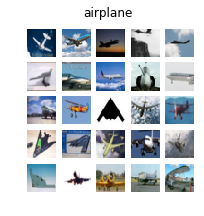

In [489]:
class_id = 0
dv.visualize_data_of_class(X_train.reshape(50000, 32, 32, 3), y_train, class_id, title=labels[class_id])

In [517]:
y_train_lr = generate_binary_classification_label_from_multiclass_labels(y_train, 10)
y = y_train_lr[class_id].reshape(-1, 1)

y_test_lr = generate_binary_classification_label_from_multiclass_labels(y_test, 10)
y_test_new = y_test_lr[class_id].reshape(-1, 1)

Iteration 0: Loss = 0.692159952417992
Iteration 100: Loss = 0.5378585210652052
Iteration 200: Loss = 0.4565793053193415
Iteration 300: Loss = 0.4034714980248197
Iteration 400: Loss = 0.36735516246301
Iteration 500: Loss = 0.3418673135721591
Iteration 600: Loss = 0.32328021291841047
Iteration 700: Loss = 0.30933461016477565
Iteration 800: Loss = 0.29861252972116564
Iteration 900: Loss = 0.29019380868189104
Iteration 1000: Loss = 0.2834627276672283
Iteration 1100: Loss = 0.27799570838107845
Iteration 1200: Loss = 0.27349402737503503
Iteration 1300: Loss = 0.2697422840317225
Iteration 1400: Loss = 0.2665820446432607
Iteration 1500: Loss = 0.2638946847946332
Iteration 1600: Loss = 0.26158995577699984
Iteration 1700: Loss = 0.2595982010547202
Iteration 1800: Loss = 0.25786495325413233
Iteration 1900: Loss = 0.25634711619164274
Iteration 2000: Loss = 0.25501022257992756
Iteration 2100: Loss = 0.25382643465325355
Iteration 2200: Loss = 0.25277306625334617
Iteration 2300: Loss = 0.251831476436

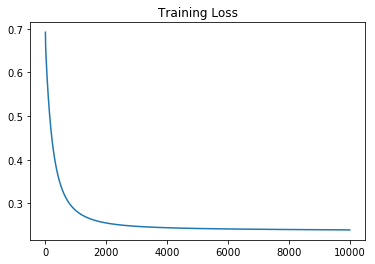

In [410]:
X, X_mean, X_std = preprocess_data(X_train, divide_by_std_dev=True, view_hists=False)
X = append_ones(X)

num_epochs = 10000
lr = LogisticRegression()
lr.train(X, y, num_epochs=num_epochs, learning_rate=0.01)

Accuracy on Training data =  91.24 1550
Accuracy on Test data =  91.04 302
Bias =  [-2.92746743]


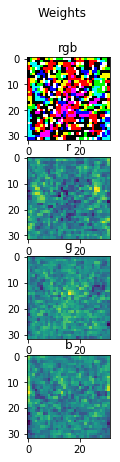

In [484]:
model_file = "logistic_regression_cifar10_class{}_epochs{}_divided_by_std_dev_{}.npy".format(class_id, num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
lr.save_model(model_file)

y_pred = lr.predict(X)
print("Accuracy on Training data = ", lr.get_accuracy(y, y_pred), np.sum(y_pred))

X_test_new,_,_ = preprocess_data(X_test, X_mean=X_mean, X_std=X_std, divide_by_std_dev=True, view_hists=False)
X_test_new = append_ones(X_test_new)
y_pred = lr.predict(X_test_new)
print("Accuracy on Test data = ", lr.get_accuracy(y_test_new, y_pred), np.sum(y_pred))

lr.load_model('./models/logistic_regression_cifar10_class0_epochs10000_divided_by_std_dev_2017_05_02-22_31_10.npy');
lr.visualize_weights()

## Test with regularization

Iteration 0: Loss = 0.6921590071640918
Iteration 100: Loss = 0.5436890485222742
Iteration 200: Loss = 0.4720086290274035
Iteration 300: Loss = 0.42809689037849985
Iteration 400: Loss = 0.3998502197474631
Iteration 500: Loss = 0.3809329180601832
Iteration 600: Loss = 0.3678472843714715
Iteration 700: Loss = 0.3585615192004702
Iteration 800: Loss = 0.35183910840627214
Iteration 900: Loss = 0.3468959214798502
Iteration 1000: Loss = 0.34321666328744704
Iteration 1100: Loss = 0.34045223546772285
Iteration 1200: Loss = 0.3383599697634743
Iteration 1300: Loss = 0.33676751124212445
Iteration 1400: Loss = 0.3355502431376007
Iteration 1500: Loss = 0.33461673628182265
Iteration 1600: Loss = 0.3338991068368609
Iteration 1700: Loss = 0.33334646552055835
Iteration 1800: Loss = 0.3329203676038601
Iteration 1900: Loss = 0.3325915906784597
Iteration 2000: Loss = 0.33233781409386404
Iteration 2100: Loss = 0.3321419236362731
Iteration 2200: Loss = 0.3319907579553214
Iteration 2300: Loss = 0.3318741722863

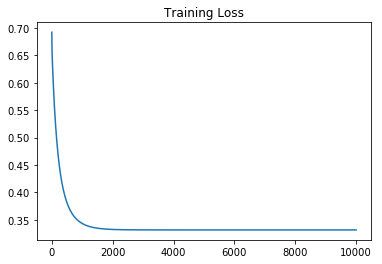

In [518]:
X, X_mean, X_std = preprocess_data(X_train, divide_by_std_dev=True, view_hists=False)
X = append_ones(X)

num_epochs = 10000
lr = LogisticRegression()
lr.train(X, y, num_epochs=num_epochs, learning_rate=0.01, enable_regularization=True, regularization_rate=0.1)

Accuracy on Training data =  91.142 1883
Accuracy on Test data =  91.14 366
Bias =  [-1.30910524]


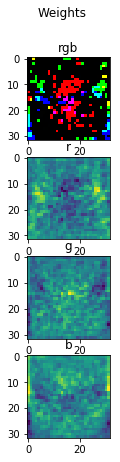

In [519]:
model_file = "logistic_regression_cifar10_class{}_epochs{}_divided_by_std_dev_regularized_{}.npy".format(class_id, num_epochs, time.strftime("%Y_%m_%d-%H_%M_%S"))
model_file = '/'.join([model_path, model_file])
lr.save_model(model_file)

y_pred = lr.predict(X)
print("Accuracy on Training data = ", lr.get_accuracy(y, y_pred), np.sum(y_pred))

X_test_new,_,_ = preprocess_data(X_test, X_mean=X_mean, X_std=X_std, divide_by_std_dev=True, view_hists=False)
X_test_new = append_ones(X_test_new)
y_pred = lr.predict(X_test_new)
print("Accuracy on Test data = ", lr.get_accuracy(y_test_new, y_pred), np.sum(y_pred))

lr.visualize_weights()

## Test with equal number of positive and negative examples

Iteration 0: Loss = 0.6797044254697683
Iteration 100: Loss = 0.5111429282728447
Iteration 200: Loss = 0.5040179941146344
Iteration 300: Loss = 0.4996819688797144
Iteration 400: Loss = 0.4964950478977778
Iteration 500: Loss = 0.493936387448142
Iteration 600: Loss = 0.49178157635723074
Iteration 700: Loss = 0.4899125135867747
Iteration 800: Loss = 0.48825794502565517
Iteration 900: Loss = 0.4867708520704378
Iteration 1000: Loss = 0.48541830696664534
Iteration 1100: Loss = 0.48417627074263164
Iteration 1200: Loss = 0.48302664256013
Iteration 1300: Loss = 0.48195545778819554
Iteration 1400: Loss = 0.48095172603146163
Iteration 1500: Loss = 0.48000665034183515
Iteration 1600: Loss = 0.4791130854289535
Iteration 1700: Loss = 0.4782651518524984
Iteration 1800: Loss = 0.4774579553334822
Iteration 1900: Loss = 0.47668737878991324
Iteration 2000: Loss = 0.47594992580029655
Iteration 2100: Loss = 0.4752426011209134
Iteration 2200: Loss = 0.4745628183371356
Iteration 2300: Loss = 0.473908327671274

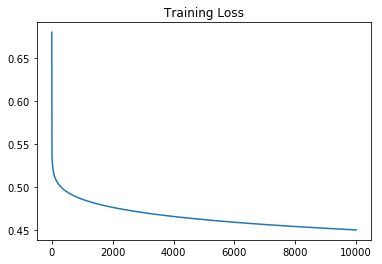

In [510]:
indexes = np.array(np.where(y_train == class_id)).flatten()
# I can either consider all images of just one other class or 555 images from each of the other 9 classes.
classes = list(range(0,10))
classes.remove(class_id)
for i in classes:
    indexes = np.concatenate((indexes, np.array(np.where(y_train == i)).flatten()[:555]))

X_train_subset = X_train[indexes]
y_train_subset = y_train[indexes]
    
y_train_lr = generate_binary_classification_label_from_multiclass_labels(y_train_subset, 10)
y = y_train_lr[class_id].reshape(-1, 1)

X, X_mean, X_std = preprocess_data(X_train_subset, divide_by_std_dev=True, view_hists=False)
X = append_ones(X)

num_epochs = 10000
lr = LogisticRegression()
lr.train(X, y, num_epochs=num_epochs, learning_rate=0.01)

Iteration 0: Loss = 0.44974395032301495
Iteration 100: Loss = 0.44956614215312135
Iteration 200: Loss = 0.4493899285700568
Iteration 300: Loss = 0.4492152802515771
Iteration 400: Loss = 0.4490421686729817
Iteration 500: Loss = 0.4488705660783922
Iteration 600: Loss = 0.44870044545331966
Iteration 700: Loss = 0.448531780498453
Iteration 800: Loss = 0.44836454560460215
Iteration 900: Loss = 0.4481987158287364
Iteration 1000: Loss = 0.4480342668710597
Iteration 1100: Loss = 0.44787117505307006
Iteration 1200: Loss = 0.4477094172965524
Iteration 1300: Loss = 0.4475489711034558
Iteration 1400: Loss = 0.4473898145366137
Iteration 1500: Loss = 0.44723192620126145
Iteration 1600: Loss = 0.4470752852273143
Iteration 1700: Loss = 0.44691987125236754
Iteration 1800: Loss = 0.446765664405382
Iteration 1900: Loss = 0.4466126452910258
Iteration 2000: Loss = 0.44646079497463564
Iteration 2100: Loss = 0.44631009496777335
Iteration 2200: Loss = 0.446160527214345
Iteration 2300: Loss = 0.446012074077259

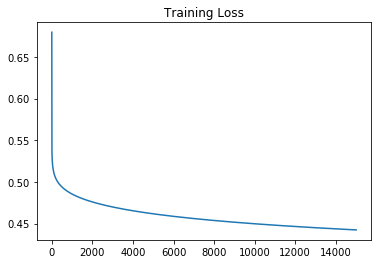

In [511]:
lr.train(X, y, num_epochs=5000, learning_rate=0.01)

Accuracy on Training data =  80.4202101051 5003
Accuracy on Test data =  73.51 3201
Bias =  [-0.01394392]


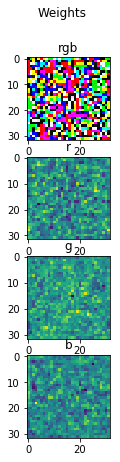

In [512]:
y_pred = lr.predict(X)
print("Accuracy on Training data = ", lr.get_accuracy(y, y_pred), np.sum(y_pred))

X_test_new,_,_ = preprocess_data(X_test, X_mean=X_mean, X_std=X_std, divide_by_std_dev=True, view_hists=False)
X_test_new = append_ones(X_test_new)
y_pred = lr.predict(X_test_new)
print("Accuracy on Test data = ", lr.get_accuracy(y_test_new, y_pred), np.sum(y_pred))

lr.visualize_weights()

Iteration 0: Loss = 0.43697440089644246
Iteration 100: Loss = 0.43687955845572246
Iteration 200: Loss = 0.43678514099998034
Iteration 300: Loss = 0.4366911444528248
Iteration 400: Loss = 0.4365975647970394
Iteration 500: Loss = 0.4365043980734599
Iteration 600: Loss = 0.43641164037987584
Iteration 700: Loss = 0.4363192878699588
Iteration 800: Loss = 0.43622733675221514
Iteration 900: Loss = 0.43613578328896263
Iteration 1000: Loss = 0.43604462379533077
Iteration 1100: Loss = 0.43595385463828407
Iteration 1200: Loss = 0.4358634722356671
Iteration 1300: Loss = 0.43577347305527153
Iteration 1400: Loss = 0.43568385361392425
Iteration 1500: Loss = 0.43559461047659515
Iteration 1600: Loss = 0.43550574025552613
Iteration 1700: Loss = 0.43541723960937784
Iteration 1800: Loss = 0.4353291052423973
Iteration 1900: Loss = 0.4352413339036017
Iteration 2000: Loss = 0.43515392238598183
Iteration 2100: Loss = 0.43506686752572193
Iteration 2200: Loss = 0.4349801662014372
Iteration 2300: Loss = 0.434893

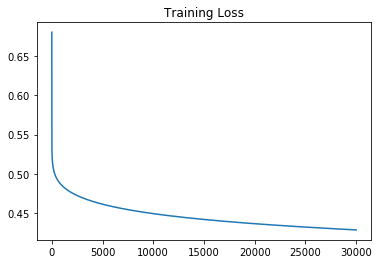

In [514]:
lr.train(X, y, num_epochs=10000, learning_rate=0.01)

## Now it is clearly overfitting !!!

After 15,000 epochs:
- Accuracy on Training data =  80.4202101051 5003
- Accuracy on Test data =  73.51 3201

After 30,000 epochs:
- Accuracy on Training data =  81.1005502751 5013
- Accuracy on Test data =  73.02 3244

##### Mistake: I should have had a validation split and checked the validation accuracy/loss too.

In [515]:
y_pred = lr.predict(X)
print("Accuracy on Training data = ", lr.get_accuracy(y, y_pred), np.sum(y_pred))
y_pred = lr.predict(X_test_new)
print("Accuracy on Test data = ", lr.get_accuracy(y_test_new, y_pred), np.sum(y_pred))

Accuracy on Training data =  81.1005502751 5013
Accuracy on Test data =  73.02 3244
